In [1]:
import os, sys
import argparse
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch
from scipy.stats import mode

from tensorboardX import SummaryWriter
import imageio
import cv2
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch

### Args:
features_file = "/Users/andreachatrian/Documents/Repositories/ProstateCancer/Results/feats_epoch_.411_loss_0.20396_acc_0.95000_dice_0.93000_lr_0.0000103566.csv"
thumbnails_file = "/Users/andreachatrian/Documents/Repositories/ProstateCancer/Results/thumbnails_epoch_.411_loss_0.20396_acc_0.95000_dice_0.93000_lr_0.0000103566.npy"
sprite_file = "/Users/andreachatrian/Documents/Repositories/ProstateCancer/Results/sprite_epoch_.411_loss_0.20396_acc_0.95000_dice_0.93000_lr_0.0000103566.png"
thumbnail_size = 64
pca_reduce = 2/3
###

def create_sprite_image(images):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))

    spriteimage = np.ones((img_h * n_plots, img_w * n_plots, 3))

    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                spriteimage[i * img_h:(i + 1) * img_h,
                j * img_w:(j + 1) * img_w] = this_img

    return spriteimage

# Preprocess

In [2]:
### Preprocessing and visualization ###
run_time = time.time()
with open(features_file, 'r') as feats_file:
    X = np.loadtxt(feats_file, skiprows=1)  # need to skip header row (?)
run_time = time.time() - run_time
print("X's shape is ", X.shape)
print("Run in {}s".format(run_time))

X's shape is  (4618, 13828)
Run in 74.30095887184143s


In [3]:
np.where(np.isnan(X[0,:]))[0]

array([13824, 13825, 13826])

# Embedding

In [7]:
# Check X:
good = np.all(np.isfinite(X))
print(good)
print(thumbnails.shape)

if not good:
    for i, tn in enumerate(thumbnails):
        X[i,13824] = tn[...,0].mean()
        X[i,13825] = tn[...,1].mean()
        X[i,13826] = tn[...,2].mean()
        
X[np.isnan(X)] = 0.0

True
(4618, 100, 100, 3)


In [8]:
# Preprocessing
X = StandardScaler().fit_transform(X)

In [10]:
# For t-SNE, PCA is recommended as a first step to reduce dimensionality
run_time = time.time()
pca = PCA(n_components=int(X.shape[1]*pca_reduce), whiten=True)  # reduce number of features
#dec = FastICA(n_components=int(X.shape[1]*pca_reduce), whiten=True, max_iter=200)
# !!! it is possible to generative negative eigenvalue and make the algorithm fail with large matrix that has determinant close to zero
# for ICA, should reduce the number of comoponents to number (rule of thumb, as many as 99% variance explanation in PCA)
pca = pca.fit(X)
X_new = pca.transform(X)
run_time = time.time() - run_time
print("X_new's shape is ", X_new.shape)
print("Run in {}s".format(run_time))

X_new's shape is  (4618, 4618)
Run in 80.0633909702301s


[5.30572529e-01 1.78258381e-01 4.24263556e-02 ... 4.68786714e-08
 4.57180960e-08 5.33629203e-33]
621


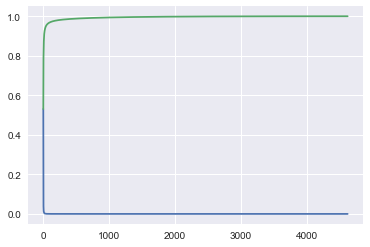

In [11]:
sns.set(style="darkgrid")
plt.plot(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_)

cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_var)
ninetynine = np.where(cum_var > 0.99)[0][0]
print(ninetynine)

In [12]:
# For t-SNE, PCA is recommended as a first step to reduce dimensionality
run_time = time.time()
dec = FastICA(n_components=ninetynine, whiten=True, max_iter=400)
# !!! it is possible to generative negative eigenvalue and make the algorithm fail with large matrix that has determinant close to zero
# for ICA, should reduce the number of comoponents to number (rule of thumb, as many as 99% variance explanation in PCA)
dec = dec.fit(X)
X_new = dec.transform(X)
run_time = time.time() - run_time
print("X_new's shape is ", X_new.shape)
print("Run in {}s".format(run_time))

/Users/andreachatrian/miniconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:1321: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  x, resids, rank, s = lstsq(a, b, cond=cond, check_finite=False)


X_new's shape is  (4618, 621)
Run in 127.89592003822327s


In [13]:
# Open thumbnails file
with open(thumbnails_file, 'rb') as tnbs_file:
    thumbnails = np.load(tnbs_file)
    
#sprite = create_sprite_image(thumbnails.astype(np.uint8).clip(0,255))

In [14]:
# t-SNE with tensorboard
log_dir = Path(features_file).parent/"projector"
try:
    os.mkdir(log_dir)
except FileExistsError:
    pass
writer = SummaryWriter(log_dir=str(log_dir))

In [15]:
X_t = torch.from_numpy(X_new)
thumbnails_t = torch.from_numpy(thumbnails).permute(0,3,1,2).type(torch.float32)  # turn to NCHW for tensorboardX embedding
print(X_t.shape)
print(thumbnails_t.shape)
writer.add_embedding(X_t, label_img=thumbnails_t)

torch.Size([4618, 621])
torch.Size([4618, 3, 100, 100])


In [ ]:
# Check thumbnails
print(thumbnails.shape)
print(np.unique(thumbnails))


In [ ]:
"""
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector


tf_X = tf.Variable(X_new, trainable=False)
saver = tf.train.Saver([tf_X])

# based on https://www.easy-tensorflow.com/tf-tutorials/tensorboard/tb-embedding-visualization
# http://www.pinchofintelligence.com/simple-introduction-to-tensorboard-embedding-visualisation/

th_size = (100,) * 2
with tf.Session() as sess:

    sess.run(tf_X.initializer)

    writer = tf.summary.FileWriter(str(log_dir /"projector"), sess.graph)

    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.tensor_name = 'embeddingding:0'
    embedding.sprite.image_path = str(log_dir/"projector"/sprite_file)
    projector.visualize_embeddings(summary_writer=writer, config=config)
    
    dir(embedding.sprite)
import inspect
inspect.getmembers(embedding.sprite)

"""

# Clustering

In [ ]:
### Clustering
birch = Birch(threshold=0.5, branching_factor=50, n_clusters=3)
birch.fit(X_new)
labels = birch.predict(X_new)


In [ ]:
import sys
sys.executable